In [1]:
using Distributions, TimeIt, ProgressMeter, PyPlot
include("zz_structures_DuLuSuSe.jl")
include("mbsampler.jl")

get_clustering (generic function with 1 method)

#### Simulate data:

In [2]:
N = 100
K = 5
Nobs = N*K

d_cov = 5
pX = 1.
X_cov = sprandn(d_cov, Nobs, pX)
ξ_true = rand(Normal(),1+d_cov+K)
σ02 = 1

d = 1+K+d_cov
prior = MM_prior(d_cov, K, 1);

In [3]:
X = spzeros(N*K,1+K+d_cov)
X[:,1] = 1.
X[:,K+2:end] = X_cov';
for k in 1:K
    X[(k-1)*N+1:k*N,k+1] = 1.
end
X = X'
y = [rand(Binomial(1, 1/(1+exp(-ξ_true'X[:,j]))), 1)[1] + 0. for j in 1:Nobs];

In [4]:
mean(y)

0.49

#### Define model:

In [5]:
my_ll = ll_logistic_sp(X,y);
my_model = model(my_ll, prior);
root = rand(d);

#### Define minibatch sampler:

In [6]:
# Stratified sub-sampling without CV and with weights 

mb_size = 2
cmbsamplers = Array{mbsampler}(d)
cmbsamplers[1] = umbsampler(0, Nobs, mb_size)

for dim in 2:(1+K)
    cmbsamplers[dim] = umbsampler(N*(dim-2), N, 1, 1., 1/(N*K))
end

weights = sparse(abs.(X))
for dim in (1+K+1):(1+K+d_cov) 
    weights[dim,:] /= sum(weights[dim,:])
end

ll_pd_root_list = [partial_derivative_vec(my_model.ll, root, dim, 1:Nobs) for dim in 1:d]
N_cluster = K
for dim in (1+K)+(1:d_cov)
    N_cluster_d = min(N_cluster, length(ll_pd_root_list[dim].nzval))
    csamplers = Array{mbsampler}(N_cluster_d)
    
    clusters = []
    for k in 1:K 
        push!(clusters,Array(N*(k-1)+1:N*k))
    end
    
    scp = ones(N_cluster_d)
    for (ci, c) in enumerate(clusters)
        if dim > 1+K 
            csamplers[ci] = wumbsampler(size(c,1), scp[ci], weights[dim,c])
#             csamplers[ci] = umbsampler(0, size(c,1), scp[ci])
        end
    end
    cmbsamplers[dim] = spcmbsampler(csamplers, clusters, weights[dim,:])
   
end
gs_list = mbsampler_list(d,cmbsamplers);

#### Define output scheduler etc:

In [22]:
A_xi = eye(d)
A_hyp = eye(hyperparam_size(prior))

opf = projopf(A_xi, A_hyp, 10^3)
opt = maxa_opt(10^7)
outp = outputscheduler(opf,opt)
bb = linear_bound(my_model.ll, my_model.pr, gs_list)
mstate = zz_state(d)
update_bound(bb, my_ll, prior, gs_list, mstate);

In [23]:
print("Initial speed = ", opf.alpha_skeleton[:,opf.tcounter+1])

Initial speed = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

In [24]:
adapt_speed = "by_var"
L = 1
my_zz_sampler = zz_sampler(0, gs_list, bb, L, adapt_speed)
hyper_sampler = block_gibbs_sampler(2e0)
blocksampler = Array{msampler}(2)
blocksampler[1] = my_zz_sampler
blocksampler[2] = hyper_sampler;

#### Run sampler:

In [25]:
ZZ_block_sample(my_model, outp, blocksampler, mstate);

10 percent attempts in 2.50 min; zz bounces = 120080, hyp bounces = 445, total time of process = 196.800 
20 percent attempts in 5.11 min; zz bounces = 244736, hyp bounces = 859, total time of process = 391.946 
30 percent attempts in 7.80 min; zz bounces = 370225, hyp bounces = 1225, total time of process = 586.195 
40 percent attempts in 10.53 min; zz bounces = 494769, hyp bounces = 1593, total time of process = 780.601 
50 percent attempts in 13.40 min; zz bounces = 618983, hyp bounces = 1952, total time of process = 974.613 
60 percent attempts in 16.33 min; zz bounces = 744397, hyp bounces = 2342, total time of process = 1168.845 
70 percent attempts in 19.31 min; zz bounces = 869343, hyp bounces = 2709, total time of process = 1363.302 
80 percent attempts in 22.33 min; zz bounces = 994338, hyp bounces = 3091, total time of process = 1557.705 
90 percent attempts in 25.38 min; zz bounces = 1119437, hyp bounces = 3481, total time of process = 1751.780 
100 percent attempts in 28.4

#### Plot speeds:

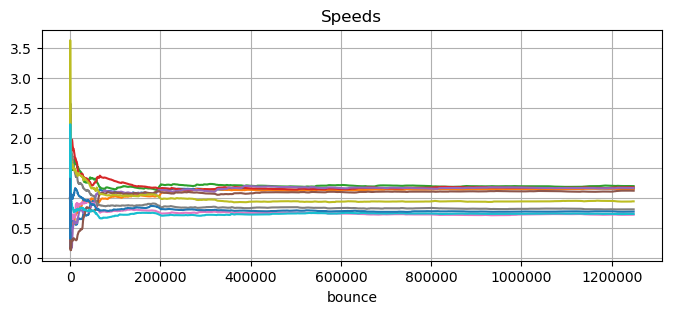

In [29]:
fig = figure("pyplot_barplot",figsize=(8,3))
for i in 1:d 
    plot((outp.opf.alpha_skeleton[i,:]))
end
title("Speeds")
xlabel("bounce")
grid(true)

#### Extract samples:

In [33]:
discard = 200_000
n_samples = 10^3
xi_samples = extract_samples(outp.opf.xi_skeleton[:,discard+1:end], 
                             outp.opf.bt_skeleton[:,discard+1:end], 
    (outp.opf.bt_skeleton[end]-outp.opf.bt_skeleton[discard])/n_samples,
                            "linear")[:,1:end-1];
hyper_samples = extract_samples(outp.opf.hyper_skeleton[:,discard+1:end], 
                                outp.opf.bt_skeleton[:,discard+1:end], 
                                (outp.opf.bt_skeleton[end]-outp.opf.bt_skeleton[discard])/n_samples, 
                                "constant");

#### Plot configuration temperatures (should be around 1):

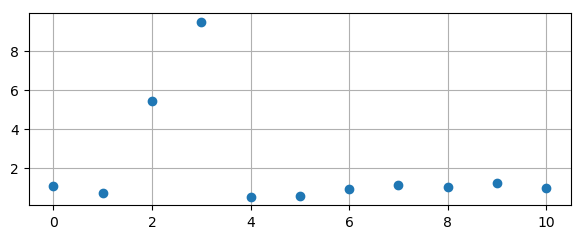

In [34]:
fig = figure("pyplot_barplot",figsize=(7,2.5))
plot([compute_configT(my_model, xi_samples[:,1:end-1], hyper_samples[:,1:end-1], k) for k in 1:d], "o")
grid(true)

In [35]:
[compute_configT(my_model, xi_samples[:,1:end-1], hyper_samples[:,1:end-1], k) for k in 1:d]

11-element Array{Float64,1}:
 1.03181 
 0.712623
 5.40897 
 9.50377 
 0.509914
 0.538651
 0.919147
 1.07674 
 1.01952 
 1.19421 
 0.947623

#### Plot ACFs:

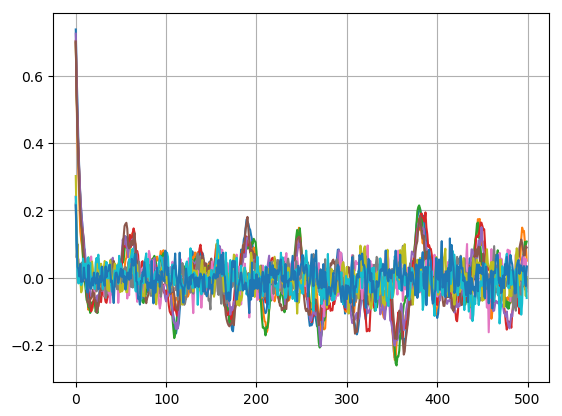

In [32]:
for i in 1:size(xi_samples,1) 
    plot(acf(xi_samples[i,:], 500))
end
grid(true)

In [15]:
[sum(acf(xi_samples[i,:], 900)) for i in 1:size(xi_samples,1)]

16-element Array{Float64,1}:
  -74.4129 
  -43.0372 
   -9.52952
 -115.492  
   -5.05359
 -272.647  
 -111.433  
  -86.532  
  -18.1734 
   22.6122 
 -112.998  
  -77.5877 
   14.1002 
  -21.152  
    3.73052
   -8.33279

### HMC:

In [28]:
prior = MM_prior(d_cov, K, 1);
my_ll = ll_logistic_sp(X,y);
my_model = model(my_ll, prior);

In [29]:
ξ0 = randn(d)
epsilon = 4e-2
L = 20
T = 500

xi_samples, hyper_samples, acc = GibbsHMC(my_model, ξ0, epsilon, L, T);

10 percent steps in 0.9 min; HMC acceptance = 72 percent 
20 percent steps in 1.8 min; HMC acceptance = 76 percent 
30 percent steps in 2.7 min; HMC acceptance = 77 percent 
40 percent steps in 3.5 min; HMC acceptance = 77 percent 
50 percent steps in 4.4 min; HMC acceptance = 76 percent 
60 percent steps in 5.3 min; HMC acceptance = 77 percent 
70 percent steps in 6.2 min; HMC acceptance = 77 percent 
80 percent steps in 7.0 min; HMC acceptance = 77 percent 
90 percent steps in 7.9 min; HMC acceptance = 76 percent 
100 percent steps in 8.8 min; HMC acceptance = 74 percent 


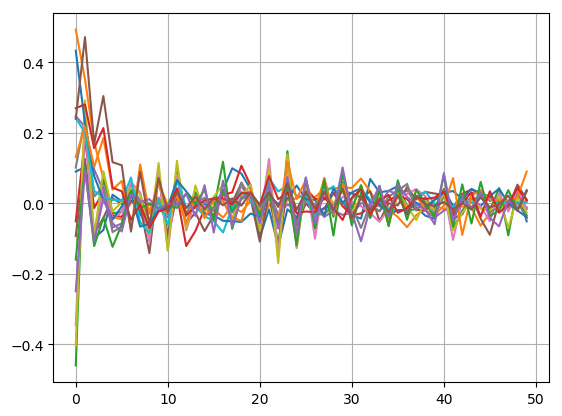

In [31]:
for i in 1:size(xi_samples,1) 
    plot(acf(xi_samples[i,:], 50))
end
grid(true)